Business Goal 8:
Determine if sentiment correlates with the team success. Identify fan sentiment throughout the season.

Technical proposal:
Identify fan sentiment in the subreddit. With the external dataset about ranking, determine whether sentiment correlates with the success of the team.

In [1]:
spark

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 48, 6, Finished, Available)

First, install the John Snow Labs package.

In [3]:
%%configure -f \
{"conf": {"spark.jars.packages": "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.2"}}

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 50, -1, Finished, Available)

Unrecognized options: 

Install the package on the Spark driver.

In [4]:
!pip install spark-nlp

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 50, 6, Finished, Available)

     |████████████████████████████████| 540 kB 10.6 MB/s eta 0:00:01


Import necessary libraries.

In [5]:
import pandas as pd
import numpy as np
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

import sparknlp
from sparknlp.annotator import *
from sparknlp.base import *
from sparknlp.pretrained import PretrainedPipeline

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 50, 7, Finished, Available)

In [6]:
from pyspark.sql.functions import col, when, to_date, weekofyear, sum, concat_ws, year

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 50, 8, Finished, Available)

Then, read in the clean data.

In [7]:
workspace_default_storage_account = "aml6214727930"
workspace_default_container = "azureml-blobstore-6653633b-3460-4381-9199-d9e0f368353c"

workspace_wasbs_base_url = (
    f"wasbs://{workspace_default_container}@{workspace_default_storage_account}.blob.core.windows.net/"
)

comments_path = "/basketball_comments_nlp.parquet"
submissions_path = "/basketball_submissions_nlp.parquet"

comments = spark.read.parquet(f"{workspace_wasbs_base_url}{comments_path}")
submissions = spark.read.parquet(f"{workspace_wasbs_base_url}{submissions_path}")

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 50, 9, Finished, Available)

In [18]:
comments.show(3)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 43, 20, Finished, Available)

+-----------------+------------+--------------------+--------------------+----------+---------+-------+-------------------+--------------+---+-----+----+--------------------+
|        subreddit|      author|   author_flair_text|                body| parent_id|  link_id|     id|        created_utc|supported_team|day|month|year|          clean_text|
+-----------------+------------+--------------------+--------------------+----------+---------+-------+-------------------+--------------+---+-----+----+--------------------+
|CollegeBasketball|DaddyStone13|:cincinnati: :big...|lol i forgot abou...|t1_hkiua9s|t3_qtcawg|hkiungs|2021-11-14 00:27:51|    cincinnati| 14|   11|2021|[lol, forget, foo...|
|CollegeBasketball| seahawksjoe|   :usc: USC Trojans|Also, half of the...| t3_qtcaw2|t3_qtcaw2|hkiuqzc|2021-11-14 00:28:36|           usc| 14|   11|2021|[half, foul, aren...|
|CollegeBasketball|CheeseAndCam|:iowastate: Iowa ...|I like how Creigh...| t3_qt70bd|t3_qt70bd|hkiuy80|2021-11-14 00:30:06|  

In [9]:
submissions.show(3)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 41, 12, Finished, Available)

+-----------------+-------------+--------------------+--------------------+--------------------+-------------------+------------+--------------+-----------+------------+---------+------------+---------+---------+--------------+---+-----+----+--------------------+
|        subreddit|       author|   author_flair_text|               title|            selftext|        created_utc|num_comments|supported_team|game_thread|home_ranking|home_team|away_ranking|away_team|game_time|ranked_matchup|day|month|year|          clean_text|
+-----------------+-------------+--------------------+--------------------+--------------------+-------------------+------------+--------------+-----------+------------+---------+------------+---------+---------+--------------+---+-----+----+--------------------+
|CollegeBasketball|      rCBBMod|:rcbb: /r/College...|Announcement: The...|Hello r/CollegeBa...|2022-03-17 14:00:50|           9|          rcbb|      false|            |         |            |         |      

In the column 'clean_text', we can see there are lists of tokens. Let's combine them together to strings and then we can do sentiment analysis on them.

In [8]:
comments = comments.withColumn('clean_text', concat_ws(' ', 'clean_text'))

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 50, 10, Finished, Available)

In [21]:
comments.show(3)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 43, 23, Finished, Available)

+-----------------+------------+--------------------+--------------------+----------+---------+-------+-------------------+--------------+---+-----+----+--------------------+
|        subreddit|      author|   author_flair_text|                body| parent_id|  link_id|     id|        created_utc|supported_team|day|month|year|          clean_text|
+-----------------+------------+--------------------+--------------------+----------+---------+-------+-------------------+--------------+---+-----+----+--------------------+
|CollegeBasketball|DaddyStone13|:cincinnati: :big...|lol i forgot abou...|t1_hkiua9s|t3_qtcawg|hkiungs|2021-11-14 00:27:51|    cincinnati| 14|   11|2021|lol forget footba...|
|CollegeBasketball| seahawksjoe|   :usc: USC Trojans|Also, half of the...| t3_qtcaw2|t3_qtcaw2|hkiuqzc|2021-11-14 00:28:36|           usc| 14|   11|2021|half foul arent f...|
|CollegeBasketball|CheeseAndCam|:iowastate: Iowa ...|I like how Creigh...| t3_qt70bd|t3_qt70bd|hkiuy80|2021-11-14 00:30:06|  

Select the DL model.

In [9]:
model_name = 'sentimentdl_use_twitter'

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 50, 11, Finished, Available)

Define the NLP pipeline.

In [10]:
documentAssembler = DocumentAssembler()\
    .setInputCol('clean_text')\
    .setOutputCol('document')

use = UniversalSentenceEncoder.pretrained(name = 'tfhub_use', lang = 'en')\
 .setInputCols(['document'])\
 .setOutputCol('sentence_embeddings')

sentimentdl = SentimentDLModel.pretrained(name = model_name, lang = 'en')\
    .setInputCols(['sentence_embeddings'])\
    .setOutputCol('sentiment')

nlpPipeline = Pipeline(
    stages = [documentAssembler,
              use,
              sentimentdl]
)


StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 50, 12, Finished, Available)

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[OK!]


Create a column 'date' based on the existing column 'created_utc'.

In [11]:
comments_nlp = comments.withColumn('date', to_date(col('created_utc')))

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 50, 13, Finished, Available)

In [23]:
comments_nlp.show(3)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 43, 25, Finished, Available)

+-----------------+------------+--------------------+--------------------+----------+---------+-------+-------------------+--------------+---+-----+----+--------------------+----------+
|        subreddit|      author|   author_flair_text|                body| parent_id|  link_id|     id|        created_utc|supported_team|day|month|year|          clean_text|      date|
+-----------------+------------+--------------------+--------------------+----------+---------+-------+-------------------+--------------+---+-----+----+--------------------+----------+
|CollegeBasketball|DaddyStone13|:cincinnati: :big...|lol i forgot abou...|t1_hkiua9s|t3_qtcawg|hkiungs|2021-11-14 00:27:51|    cincinnati| 14|   11|2021|lol forget footba...|2021-11-14|
|CollegeBasketball| seahawksjoe|   :usc: USC Trojans|Also, half of the...| t3_qtcaw2|t3_qtcaw2|hkiuqzc|2021-11-14 00:28:36|           usc| 14|   11|2021|half foul arent f...|2021-11-14|
|CollegeBasketball|CheeseAndCam|:iowastate: Iowa ...|I like how Creigh

Get information about the week of the year using 'weekofyear'.

In [12]:
comments_nlp = comments_nlp.withColumn('week', weekofyear('date'))

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 50, 14, Finished, Available)

In [25]:
comments_nlp.show(3)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 43, 27, Finished, Available)

+-----------------+------------+--------------------+--------------------+----------+---------+-------+-------------------+--------------+---+-----+----+--------------------+----------+----+
|        subreddit|      author|   author_flair_text|                body| parent_id|  link_id|     id|        created_utc|supported_team|day|month|year|          clean_text|      date|week|
+-----------------+------------+--------------------+--------------------+----------+---------+-------+-------------------+--------------+---+-----+----+--------------------+----------+----+
|CollegeBasketball|DaddyStone13|:cincinnati: :big...|lol i forgot abou...|t1_hkiua9s|t3_qtcawg|hkiungs|2021-11-14 00:27:51|    cincinnati| 14|   11|2021|lol forget footba...|2021-11-14|  45|
|CollegeBasketball| seahawksjoe|   :usc: USC Trojans|Also, half of the...| t3_qtcaw2|t3_qtcaw2|hkiuqzc|2021-11-14 00:28:36|           usc| 14|   11|2021|half foul arent f...|2021-11-14|  45|
|CollegeBasketball|CheeseAndCam|:iowastate: I

Run the pipeline.

In [13]:
the_comments_model = nlpPipeline.fit(comments_nlp)
comments_sentiment_result = the_comments_model.transform(comments_nlp)
comments_sentiment_result.show(3)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 50, 15, Finished, Available)

+-----------------+------------+--------------------+--------------------+----------+---------+-------+-------------------+--------------+---+-----+----+--------------------+----------+----+--------------------+--------------------+--------------------+
|        subreddit|      author|   author_flair_text|                body| parent_id|  link_id|     id|        created_utc|supported_team|day|month|year|          clean_text|      date|week|            document| sentence_embeddings|           sentiment|
+-----------------+------------+--------------------+--------------------+----------+---------+-------+-------------------+--------------+---+-----+----+--------------------+----------+----+--------------------+--------------------+--------------------+
|CollegeBasketball|DaddyStone13|:cincinnati: :big...|lol i forgot abou...|t1_hkiua9s|t3_qtcawg|hkiungs|2021-11-14 00:27:51|    cincinnati| 14|   11|2021|lol forget footba...|2021-11-14|  45|[{document, 0, 49...|[{sentence_embedd...|[{cate

See the sentiment analysis results.

In [16]:
comments_sentiment_results = comments_sentiment_result.select('subreddit','author','author_flair_text', 'body','parent_id','link_id','id','created_utc','supported_team','day','month','year','clean_text','date','week', F.explode('sentiment.result'))

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 50, 18, Finished, Available)

In [15]:
comments_sentiment_results.show(3)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 50, 17, Finished, Available)

+-----------------+------------+--------------------+--------------------+----------+---------+-------+-------------------+--------------+---+-----+----+--------------------+----------+----+--------+
|        subreddit|      author|   author_flair_text|                body| parent_id|  link_id|     id|        created_utc|supported_team|day|month|year|          clean_text|      date|week|     col|
+-----------------+------------+--------------------+--------------------+----------+---------+-------+-------------------+--------------+---+-----+----+--------------------+----------+----+--------+
|CollegeBasketball|DaddyStone13|:cincinnati: :big...|lol i forgot abou...|t1_hkiua9s|t3_qtcawg|hkiungs|2021-11-14 00:27:51|    cincinnati| 14|   11|2021|lol forget footba...|2021-11-14|  45|negative|
|CollegeBasketball| seahawksjoe|   :usc: USC Trojans|Also, half of the...| t3_qtcaw2|t3_qtcaw2|hkiuqzc|2021-11-14 00:28:36|           usc| 14|   11|2021|half foul arent f...|2021-11-14|  45|negative|


Try to save the dataframe.

In [18]:

workspace_default_storage_account = "group26astorage35a27acbd"
workspace_default_container = "azureml-blobstore-570461b0-0642-4dca-b42c-0c43e1c96eec"

workspace_wasbs_base_url = (
    f"wasbs://{workspace_default_container}@{workspace_default_storage_account}.blob.core.windows.net/"
)
comments_sentiment_results.write.mode("overwrite").parquet(f"{workspace_wasbs_base_url}/basketball_comments_sentiment.parquet")



StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 50, 20, Finished, Available)

Py4JJavaError: An error occurred while calling o6137.parquet.
: org.apache.hadoop.fs.azure.AzureException: java.util.NoSuchElementException: An error occurred while enumerating the result, check the original exception for details.
	at org.apache.hadoop.fs.azure.AzureNativeFileSystemStore.retrieveMetadata(AzureNativeFileSystemStore.java:2223)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem.getAncestor(NativeAzureFileSystem.java:2973)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem.mkdirs(NativeAzureFileSystem.java:2999)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem.mkdirs(NativeAzureFileSystem.java:2986)
	at org.apache.hadoop.fs.FileSystem.mkdirs(FileSystem.java:2388)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.setupJob(FileOutputCommitter.java:356)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.setupJob(HadoopMapReduceCommitProtocol.scala:205)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:187)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:187)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:104)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:91)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:103)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:481)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:82)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:481)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:457)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:103)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:87)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:81)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:125)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:872)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:406)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:374)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:241)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:805)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.util.NoSuchElementException: An error occurred while enumerating the result, check the original exception for details.
	at com.microsoft.azure.storage.core.LazySegmentedIterator.hasNext(LazySegmentedIterator.java:113)
	at org.apache.hadoop.fs.azure.StorageInterfaceImpl$WrappingIterator.hasNext(StorageInterfaceImpl.java:148)
	at org.apache.hadoop.fs.azure.AzureNativeFileSystemStore.retrieveMetadata(AzureNativeFileSystemStore.java:2202)
	... 48 more
Caused by: com.microsoft.azure.storage.StorageException: The specified container does not exist.
	at com.microsoft.azure.storage.StorageException.translateException(StorageException.java:87)
	at com.microsoft.azure.storage.core.StorageRequest.materializeException(StorageRequest.java:315)
	at com.microsoft.azure.storage.core.ExecutionEngine.executeWithRetry(ExecutionEngine.java:185)
	at com.microsoft.azure.storage.core.LazySegmentedIterator.hasNext(LazySegmentedIterator.java:109)
	... 50 more


In [15]:
comments_sentiment_result.select('subreddit', 'year', 'week', F.explode('sentiment.result')).show(3, truncate=False)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 18, Finished, Available)

+-----------------+----+----+--------+
|subreddit        |year|week|col     |
+-----------------+----+----+--------+
|CollegeBasketball|2021|45  |negative|
|CollegeBasketball|2021|45  |negative|
|CollegeBasketball|2021|45  |positive|
+-----------------+----+----+--------+
only showing top 3 rows



Since we focus on the question that determining if sentiment results correlate with team success, we just select the columns we want for further analysis. 

In [16]:
sentiment_comments = comments_sentiment_result.select('subreddit','year', 'week',F.explode('sentiment.result'))

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 19, Finished, Available)

Filter the dataframe to get a new dataframe about Kansas and a new dataframe about UNC.

In [17]:
sentiment_comments_kansas = sentiment_comments.filter(sentiment_comments.subreddit == 'jayhawks')
sentiment_comments_unc = sentiment_comments.filter(sentiment_comments.subreddit == 'tarheels')

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 20, Finished, Available)

In [18]:
sentiment_comments_kansas.show(3)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 21, Finished, Available)

+---------+----+----+--------+
|subreddit|year|week|     col|
+---------+----+----+--------+
| jayhawks|2022|  11|positive|
| jayhawks|2022|  11|negative|
| jayhawks|2022|  11|positive|
+---------+----+----+--------+
only showing top 3 rows



To keep the analysis process clear and easy to understand, we focus on the positive comments.

In [19]:
sentiment_comments_kansas_po = sentiment_comments_kansas.filter(col('col') == 'positive')

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 22, Finished, Available)

Now let's group by the positive comments from 'jayhawks' using 'year' and 'week' to see some results.

In [21]:
sentiment_comments_kansas_po.groupBy('year','week').count().show(5)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 24, Finished, Available)

+----+----+-----+
|year|week|count|
+----+----+-----+
|2022|  10|  101|
|2022|  14|  382|
|2021|  51|   23|
|2022|  52|   30|
|2021|  45|   93|
+----+----+-----+
only showing top 5 rows



From the table above, we can see there are many positive results in the 14 week of 2022. That was around March or April of 2022. That makes sense because that was the end of the basketball season and people must be talking a lot about the games.

Now let's look at the positive comments from 'tarheels'.

In [20]:
sentiment_comments_unc_po = sentiment_comments_unc.filter(col('col') == 'positive')

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 23, Finished, Available)

In [22]:
sentiment_comments_unc_po.groupBy('year','week').count().show(5)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 25, Finished, Available)

+----+----+-----+
|year|week|count|
+----+----+-----+
|2022|  10|    4|
|2022|  14|   72|
|2022|  11|   35|
|2022|   5|    3|
|2021|  41|    2|
+----+----+-----+
only showing top 5 rows



From the table above, we can see that generally the numbers of positive comments from 'tarheels' were much smaller than those from 'jayhawks'.

In [23]:
sentiment_comments_kansas_pcount = sentiment_comments_kansas_po.groupBy('year','week').count()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 26, Finished, Available)

In [24]:
sentiment_comments_unc_pcount = sentiment_comments_unc_po.groupBy('year','week').count()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 27, Finished, Available)

Let's save the dataframes and spit each dataframe into two parts, one for 2021 and one for 2022, which makes it easier for further analysis.

In [25]:
sentiment_comments_kansas_pcount_2021 = sentiment_comments_kansas_pcount.filter(col('year') == 2021)
sentiment_comments_kansas_pcount_2022 = sentiment_comments_kansas_pcount.filter(col('year') == 2022)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 28, Finished, Available)

In [26]:
sentiment_comments_unc_pcount_2021 = sentiment_comments_unc_pcount.filter(col('year') == 2021)
sentiment_comments_unc_pcount_2022 = sentiment_comments_unc_pcount.filter(col('year') == 2022)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 29, Finished, Available)

Make the dataframes ordered by 'week' for comparison later. 

In [53]:
sentiment_comments_kansas_pcount_2021 = sentiment_comments_kansas_pcount_2021.orderBy('week')
sentiment_comments_kansas_pcount_2022 = sentiment_comments_kansas_pcount_2022.orderBy('week')
sentiment_comments_unc_pcount_2021 = sentiment_comments_unc_pcount_2021.orderBy('week')
sentiment_comments_unc_pcount_2022 = sentiment_comments_unc_pcount_2022.orderBy('week')

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 56, Finished, Available)

In [54]:
sentiment_comments_kansas_pcount_2021.show(3)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 57, Finished, Available)

+----+----+-----+
|year|week|count|
+----+----+-----+
|2021|  35|   26|
|2021|  36|   20|
|2021|  37|    9|
+----+----+-----+
only showing top 3 rows



Transform the dataframes into pandas dataframes.

In [55]:
sentiment_comments_kansas_pcount_2021_pd = sentiment_comments_kansas_pcount_2021.toPandas()
sentiment_comments_kansas_pcount_2022_pd = sentiment_comments_kansas_pcount_2022.toPandas()
sentiment_comments_unc_pcount_2021_pd = sentiment_comments_unc_pcount_2021.toPandas()
sentiment_comments_unc_pcount_2022_pd = sentiment_comments_unc_pcount_2022.toPandas()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 58, Finished, Available)

In [2]:
spark.stop()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 45, 7, Finished, Available)

In [50]:
sentiment_comments_kansas_pcount_2021_pd.columns

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 43, 52, Finished, Available)

Index(['year', 'week', 'count'], dtype='object')

Now let's add in the external dataset to help to answer our question 8.

In [33]:
url = 'https://www.sports-reference.com/cbb/seasons/men/2022-polls.html'
rankings = pd.read_html(url, header=2)[0]


StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 36, Finished, Available)

We focus on the most two successful teams in this basketball season so let's extract the row of 'Kansas' and the row of 'UNC'.

In [34]:
kansas_ranking = rankings[rankings['School'] == 'Kansas']
unc_ranking = rankings[rankings['School'] == 'UNC']

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 37, Finished, Available)

The Kansas ranking data looks like this. From the ranking, it seems that Kansas is a really good team.

In [27]:
kansas_ranking

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 45, 32, Finished, Available)

,School,Conf,Pre,11/15,11/22,11/29,12/6,12/13,12/20,12/27,...,1/10,1/17,1/24,1/31,2/7,2/14,2/21,2/28,3/7,Final
17,Kansas,Big 12,3,3,4,8,8,7,7,6,...,9,7,5,10,8,6,5,6,6,3


However, the unc ranking is not that good. There are lots of missing values. It turns out that the unc team is not very good during the regular season.

In [8]:
unc_ranking

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 45, 13, Finished, Available)

,School,Conf,Pre,11/15,11/22,11/29,12/6,12/13,12/20,12/27,...,1/10,1/17,1/24,1/31,2/7,2/14,2/21,2/28,3/7,Final
41,UNC,ACC,19,18,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,NaN


Because there are lots of missing values in the UNC ranking, to answer the question 8, we have to focus on the Kansas team.

Let's clean the Kansas ranking data and change the column names of it.

In [35]:
kansas_ranking = kansas_ranking.T.reset_index().iloc[3:]

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 38, Finished, Available)

In [85]:
kansas_ranking


StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 45, 91, Finished, Available)

,index,17
3,11/15,3
4,11/22,4
5,11/29,8
6,12/6,8
7,12/13,7
8,12/20,7
9,12/27,6
10,1/3,6
11,1/10,9
12,1/17,7


In [10]:
kansas_ranking.columns

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 45, 15, Finished, Available)

Index(['index', 17], dtype='object')

In [36]:
kansas_ranking = kansas_ranking.rename(columns = {"index":"date", 17:'rank'})

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 39, Finished, Available)

In [37]:
kansas_ranking

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 40, Finished, Available)

,date,rank
3,11/15,3
4,11/22,4
5,11/29,8
6,12/6,8
7,12/13,7
8,12/20,7
9,12/27,6
10,1/3,6
11,1/10,9
12,1/17,7


Similarly, let's divide the Kansas ranking data into two parts, one for 2021 and the other for 2022.

In [38]:
kansas_ranking_2021 = kansas_ranking.iloc[:7].copy()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 41, Finished, Available)

In [39]:
kansas_ranking_2022 = kansas_ranking.iloc[7:].copy()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 42, Finished, Available)

In [101]:
kansas_ranking_2022

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 45, 107, Finished, Available)

,date,rank
10,1/3,6
11,1/10,9
12,1/17,7
13,1/24,5
14,1/31,10
15,2/7,8
16,2/14,6
17,2/21,5
18,2/28,6
19,3/7,6


In [40]:
kansas_ranking_2022 = kansas_ranking_2022.replace('Final', '3/14')

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 43, Finished, Available)

In [41]:
kansas_ranking_2021

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 44, Finished, Available)

,date,rank
3,11/15,3
4,11/22,4
5,11/29,8
6,12/6,8
7,12/13,7
8,12/20,7
9,12/27,6


In [42]:
kansas_ranking_2022

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 45, Finished, Available)

,date,rank
10,1/3,6
11,1/10,9
12,1/17,7
13,1/24,5
14,1/31,10
15,2/7,8
16,2/14,6
17,2/21,5
18,2/28,6
19,3/7,6


Let's change the format of 'date' so we can extract the information about the week of the year from it.

In [43]:
kansas_ranking_2021['date'] = kansas_ranking_2021['date'].str.replace('/','-')
kansas_ranking_2022['date'] = kansas_ranking_2022['date'].str.replace('/','-')

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 46, Finished, Available)

In [44]:
kansas_ranking_2022

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 47, Finished, Available)

,date,rank
10,1-3,6
11,1-10,9
12,1-17,7
13,1-24,5
14,1-31,10
15,2-7,8
16,2-14,6
17,2-21,5
18,2-28,6
19,3-7,6


In [45]:
kansas_ranking_2021['date'] = '2021-' + kansas_ranking_2021['date'].astype(str)
kansas_ranking_2022['date'] = '2022-' + kansas_ranking_2022['date'].astype(str)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 48, Finished, Available)

In [46]:
kansas_ranking_2021

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 49, Finished, Available)

,date,rank
3,2021-11-15,3
4,2021-11-22,4
5,2021-11-29,8
6,2021-12-6,8
7,2021-12-13,7
8,2021-12-20,7
9,2021-12-27,6


In [47]:
kansas_ranking_2022

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 50, Finished, Available)

,date,rank
10,2022-1-3,6
11,2022-1-10,9
12,2022-1-17,7
13,2022-1-24,5
14,2022-1-31,10
15,2022-2-7,8
16,2022-2-14,6
17,2022-2-21,5
18,2022-2-28,6
19,2022-3-7,6


In [48]:
kansas_ranking_2021['date'] = pd.to_datetime(kansas_ranking_2021['date'])
kansas_ranking_2022['date'] = pd.to_datetime(kansas_ranking_2022['date'])

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 51, Finished, Available)

In [49]:
kansas_ranking_2021['week']= kansas_ranking_2021['date'].dt.week

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 52, Finished, Available)

/tmp/ipykernel_28510/3244876404.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  kansas_ranking_2021['week']= kansas_ranking_2021['date'].dt.week


In [126]:
kansas_ranking_2021

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 45, 132, Finished, Available)

,date,rank,week
3,2021-11-15,3,46
4,2021-11-22,4,47
5,2021-11-29,8,48
6,2021-12-06,8,49
7,2021-12-13,7,50
8,2021-12-20,7,51
9,2021-12-27,6,52


In [50]:
kansas_ranking_2022['week'] = kansas_ranking_2022['date'].dt.week

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 53, Finished, Available)

/tmp/ipykernel_28510/2593785924.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  kansas_ranking_2022['week'] = kansas_ranking_2022['date'].dt.week


In [128]:
kansas_ranking_2022

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 45, 134, Finished, Available)

,date,rank,week
10,2022-01-03,6,1
11,2022-01-10,9,2
12,2022-01-17,7,3
13,2022-01-24,5,4
14,2022-01-31,10,5
15,2022-02-07,8,6
16,2022-02-14,6,7
17,2022-02-21,5,8
18,2022-02-28,6,9
19,2022-03-07,6,10


In [61]:
sentiment_comments_kansas_pcount_2021_pd

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 64, Finished, Available)

,year,week,count
0,2021,35,26
1,2021,36,20
2,2021,37,9
3,2021,38,3
4,2021,39,15
5,2021,40,21
6,2021,41,37
7,2021,42,23
8,2021,43,7
9,2021,44,58


From the two tables about the information of Kansas in 2021, 

In [58]:
spark.stop()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 61, Finished, Available)

Now let's plot the ranking information and the counts of positive comments in the same figure to see if we can find something interesting.

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 66, Finished, Available)

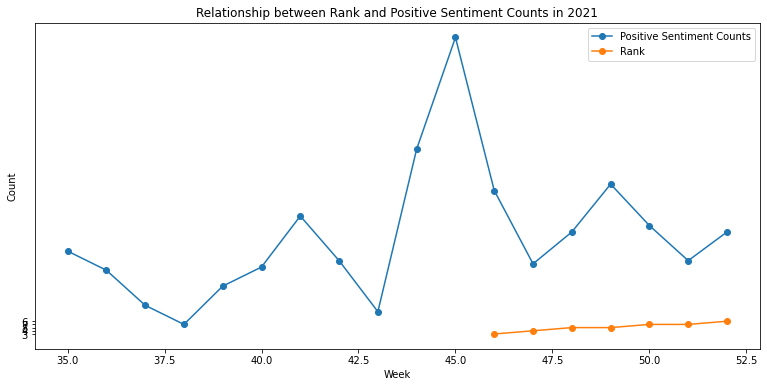

In [63]:
plt.figure(figsize = (13,6))
plt.plot(sentiment_comments_kansas_pcount_2021_pd['week'], sentiment_comments_kansas_pcount_2021_pd['count'], label = 'Positive Sentiment Counts', marker = 'o')
plt.plot(kansas_ranking_2021['week'], kansas_ranking_2021['rank'], label = 'Rank', marker = 'o')
plt.xlabel('Week')
plt.ylabel('Count')
plt.title('Relationship between Rank and Positive Sentiment Counts in 2021')
plt.legend()

From the first figure, we can see that at the beginning of this basketball season there are lots of positive comments in the 'Kansas' subreddit. The Kansas team must have lots of fans. However, we can't tell there are much relationship between the counts of positive comments and the ranking of the team in 2021.

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 47, 65, Finished, Available)

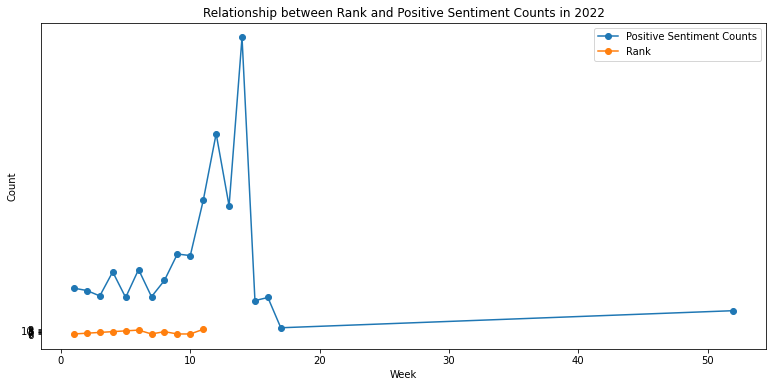

In [62]:
plt.figure(figsize = (13,6))
plt.plot(sentiment_comments_kansas_pcount_2022_pd['week'], sentiment_comments_kansas_pcount_2022_pd['count'], label = 'Positive Sentiment Counts', marker = 'o')
plt.plot(kansas_ranking_2022['week'], kansas_ranking_2022['rank'], label = 'Rank', marker = 'o')
plt.xlabel('Week')
plt.ylabel('Count')
plt.title('Relationship between Rank and Positive Sentiment Counts in 2022')
plt.legend()

Similarly, let's focus on the blue line about positive sentiment counts. The blue line goes up and down and finally the number of positive comments increases drastically. We know that Kansas won in the end so that must be people cheering the success of Kansas in the 'jayhawks' subreddit.

In the end, we are not so sure of the relationship between the comments sentiment and the performance of the team. Actually, if a team does not do so well in a game, the fans can cheer them up, say positive words and be patient about it, but the fans can also get frustrated. It is hard to determine the reaction of the fans.

In [ ]:
# sentiment_comments_kansas_pcount_2021_pd
# sentiment_comments_kansas_pcount_2022_pd
# sentiment_comments_unc_pcount_2021_pd
# sentiment_comments_unc_pcount_2022_pd
# kansas_ranking_2021
# kansas_ranking_2022